In [2]:
import ee
import geemap

ee.Authenticate()
ee.Initialize()

c:\Software Projects\Data Projects\uhi-modelling\uhenv\Lib\site-packages\geemap\conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Getting Lagos Shapefile and Converting to GeoJSON

In [3]:
import geopandas as gpd
import json

nigeria = gpd.read_file("data/shapefiles/gadm41_NGA_2.shp")
lagos = nigeria[nigeria["NAME_1"] == "Lagos"]

lagos_geom = lagos.unary_union

# Convert to GeoJSON format
lagos_geojson = json.loads(gpd.GeoSeries([lagos_geom]).to_json())["features"][0][
    "geometry"
]

lagos_aoi = ee.Geometry(lagos_geojson)

C:\Users\djmck\AppData\Local\Temp\ipykernel_7772\1980568305.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lagos_geom = lagos.unary_union


# Extracting and Aggregating Features

## Spectral Indices

### NDVI and NDBI (Built-up)

In [3]:
image = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(lagos_aoi)
    .filterDate("2022-01-01", "2022-12-31")
    .median()
    .clip(lagos_aoi)
)

# Calculate NDVI
ndvi = image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")

# Calculate Land Surface Temperature (LST)
lst = image.select("ST_B10").multiply(0.00341802).add(149).rename("LST")

# Calculate NDBI
ndbi = image.normalizedDifference(["SR_B6", "SR_B5"]).rename("NDBI")

# Combine bands
combined = ndvi.addBands(lst)

Map = geemap.Map(center=[6.5244, 3.3792], zoom=10)
Map.addLayer(ndvi, {"min": 0, "max": 1, "palette": ["white", "green"]}, "NDVI")
Map.addLayer(lst, {"min": 290, "max": 320, "palette": ["blue", "red"]}, "LST")
Map.addLayer(
    ndbi, {"min": -0.5, "max": 0.5, "palette": ["blue", "white", "green"]}, "NDBI"
)
Map.addLayerControl()
Map

Map(center=[6.5244, 3.3792], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

### MNDWI (Water)

In [4]:
mndwi = image.normalizedDifference(["SR_B3", "SR_B6"]).rename("MNDWI")

### SAVI (Vegetation)

In [5]:
savi = image.expression(
    "((NIR - RED) / (NIR + RED + L)) * (1 + L)",
    {
        "NIR": image.select("SR_B5"),
        "RED": image.select("SR_B4"),
        "L": 0.5,  # soil brightness correction factor
    },
).rename("SAVI")

## Albedo (simplified estimate)

In [6]:
albedo = image.expression(
    "0.356 * B2 + 0.130 * B4 + 0.373 * B5 + 0.085 * B6 + 0.072 * B7 - 0.0018",
    {
        "B2": image.select("SR_B2"),
        "B4": image.select("SR_B4"),
        "B5": image.select("SR_B5"),
        "B6": image.select("SR_B6"),
        "B7": image.select("SR_B7"),
    },
).rename("Albedo")


## Elevation (SRTM)

In [7]:
elevation = ee.Image("USGS/SRTMGL1_003").clip(lagos_aoi).rename("Elevation")

## Land Cover (e.g., ESA WorldCover)

In [8]:
landcover = ee.Image("ESA/WorldCover/v100/2020").clip(lagos_aoi).rename("LandCover")

# Merging Features into One Image

In [9]:
features = ndvi.addBands([ndbi, mndwi, savi, albedo, lst, elevation, landcover])

# Sampling Data from Feature Image

This can be done by grid or, in our case, by points (e.g., 200 random pixels):

In [ ]:
points = features.sample(
    region=lagos_aoi, scale=30, numPixels=200, geometries=True, seed=50
)


def add_latlon(feature):
    coords = feature.geometry().coordinates()
    lon = coords.get(0)
    lat = coords.get(1)
    return feature.set({"longitude": lon, "latitude": lat})


# Map the function over the FeatureCollection to add the lat/lon properties
points_with_latlon = points.map(add_latlon)


# Exporting Data to Local or Google Drive

For Local:

In [ ]:
geemap.ee_to_csv(points_with_latlon, filename="data/UHI_200_features.csv")

# Using the Data in Python for Modeling

In [ ]:
import pandas as pd

uhi_features = pd.read_csv("data/UHI_200_features.csv")

print(uhi_features.head())
print(uhi_features.info())

       Albedo  Elevation         LST  LandCover     MNDWI      NDBI      NDVI  \
0  15019.7662         18  298.022254         10 -0.112645 -0.164508  0.281312   
1   9437.6502          0  301.641937         80 -0.056986 -0.048300  0.131416   
2  15982.7877          9  296.919943         10 -0.156783 -0.081515  0.215554   
3  13823.5322          6  307.083425         50 -0.119996  0.011778  0.076754   
4  12412.8202          4  302.672470         95 -0.101082 -0.195369  0.298264   

       SAVI  latitude  longitude  
0  0.421961  6.679750   4.054622  
1  0.197118  6.430854   4.100493  
2  0.323326  6.534051   3.793818  
3  0.115129  6.428361   3.417995  
4  0.447388  6.594710   3.447086  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Albedo     500 non-null    float64
 1   Elevation  500 non-null    int64  
 2   LST        500 non-null    float6

In [18]:
print(uhi_features["LandCover"].value_counts())

LandCover
10    178
50    109
80     76
30     68
90     33
60     17
95     10
20      7
40      2
Name: count, dtype: int64


In [19]:
landcover_order = [
    80,  # Permanent Water Bodies (coolest)
    90,  # Herbaceous Wetlands
    10,  # Tree Cover
    20,  # Shrubland
    30,  # Grassland
    40,  # Cropland
    95,  # Mangroves
    # 100,  # Moss and Lichen
    60,  # Bare / Sparse Vegetation
    50,  # Built-up (hottest)
]

uhi_features["LandCover"] = uhi_features["LandCover"].astype("category")
uhi_features["LandCover"] = uhi_features["LandCover"].cat.reorder_categories(
    landcover_order, ordered=True
)

print(uhi_features["LandCover"].cat.categories)

Index([80, 90, 10, 20, 30, 40, 95, 60, 50], dtype='int64')


In [20]:
import numpy as np
from pyfonts import load_google_font

for column in uhi_features.columns:
    if uhi_features[column].dtype == "float":
        uhi_features[column] = uhi_features[column].round(2)

landcover_grouping = {
    "Greenery": [10, 20, 30, 40, 95, 90],
    "Water": [80],
    "Buildings": [50],
    "Bare": [60],
}

uhi_features["LST_C"] = uhi_features["LST"] - 273.15
uhi_features.rename(columns={"LST": "LST_K"}, inplace=True)
uhi_features["Landcover Category"] = np.nan
for row in range(uhi_features.shape[0]):
    if uhi_features.loc[row, "LandCover"] in landcover_grouping["Greenery"]:
        uhi_features.loc[row, "Landcover Category"] = "Greenery"
    elif uhi_features.loc[row, "LandCover"] in landcover_grouping["Water"]:
        uhi_features.loc[row, "Landcover Category"] = "Water"
    elif uhi_features.loc[row, "LandCover"] in landcover_grouping["Buildings"]:
        uhi_features.loc[row, "Landcover Category"] = "Buildings"
    elif uhi_features.loc[row, "LandCover"] in landcover_grouping["Bare"]:
        uhi_features.loc[row, "Landcover Category"] = "Bare"

print(uhi_features.head())


worldcover_colors = {
    10: (0 / 255, 100 / 255, 0 / 255),
    20: (255 / 255, 187 / 255, 34 / 255),
    30: (255 / 255, 255 / 255, 76 / 255),
    40: (240 / 255, 150 / 255, 255 / 255),
    50: (250 / 255, 0 / 255, 0 / 255),
    60: (180 / 255, 180 / 255, 180 / 255),
    70: (240 / 255, 240 / 255, 240 / 255),
    80: (0 / 255, 100 / 255, 200 / 255),
    90: (0 / 255, 150 / 255, 160 / 255),
    95: (0 / 255, 207 / 255, 117 / 255),
    100: (250 / 255, 230 / 255, 160 / 255),
}

     Albedo  Elevation   LST_K LandCover  MNDWI  NDBI  NDVI  SAVI  latitude  \
0  15019.77         18  298.02        10  -0.11 -0.16  0.28  0.42      6.68   
1   9437.65          0  301.64        80  -0.06 -0.05  0.13  0.20      6.43   
2  15982.79          9  296.92        10  -0.16 -0.08  0.22  0.32      6.53   
3  13823.53          6  307.08        50  -0.12  0.01  0.08  0.12      6.43   
4  12412.82          4  302.67        95  -0.10 -0.20  0.30  0.45      6.59   

   longitude  LST_C Landcover Category  
0       4.05  24.87           Greenery  
1       4.10  28.49              Water  
2       3.79  23.77           Greenery  
3       3.42  33.93          Buildings  
4       3.45  29.52           Greenery  


In [21]:
print(uhi_features.head())
# That's better.

     Albedo  Elevation   LST_K LandCover  MNDWI  NDBI  NDVI  SAVI  latitude  \
0  15019.77         18  298.02        10  -0.11 -0.16  0.28  0.42      6.68   
1   9437.65          0  301.64        80  -0.06 -0.05  0.13  0.20      6.43   
2  15982.79          9  296.92        10  -0.16 -0.08  0.22  0.32      6.53   
3  13823.53          6  307.08        50  -0.12  0.01  0.08  0.12      6.43   
4  12412.82          4  302.67        95  -0.10 -0.20  0.30  0.45      6.59   

   longitude  LST_C Landcover Category  
0       4.05  24.87           Greenery  
1       4.10  28.49              Water  
2       3.79  23.77           Greenery  
3       3.42  33.93          Buildings  
4       3.45  29.52           Greenery  


## Visualizations

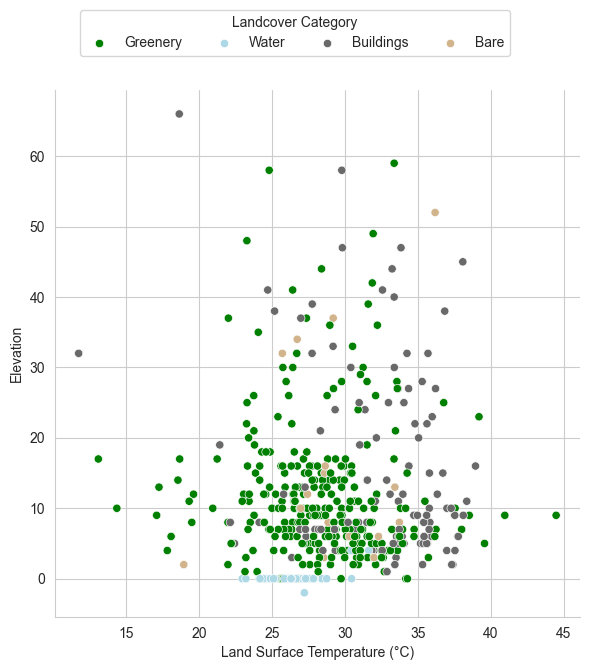

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

worldcover_labels = {
    10: "Tree Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/Sparse Veg.",
    70: "Snow/Ice",
    80: "Permanent Water",
    90: "Herbaceous Wetland",
    95: "Mangroves",
    100: "Moss/Lichen",
}

custom_palette = {
    "Bare": "tan",
    "Greenery": "green",
    "Buildings": "dimgrey",
    "Water": "lightblue",
}

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(6, 6))

    sns.scatterplot(
        x="LST_C",
        y="Elevation",
        hue="Landcover Category",
        palette=custom_palette,
        data=uhi_features,
        ax=ax,
    )
    sns.despine()

    handles, labels = ax.get_legend_handles_labels()

    # new_labels = [worldcover_labels.get(int(label), label) for label in labels]

    ax.get_legend().remove()
    ax.set_xlabel("Land Surface Temperature (°C)")
    ax.set_ylabel("Elevation")

    fig.legend(
        handles,
        labels,
        # new_labels,
        title="Landcover Category",
        ncol=5,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.12),
        prop={"size": 10},
        # frameon=False
    )

    plt.tight_layout()
    plt.show()


### Box Plot

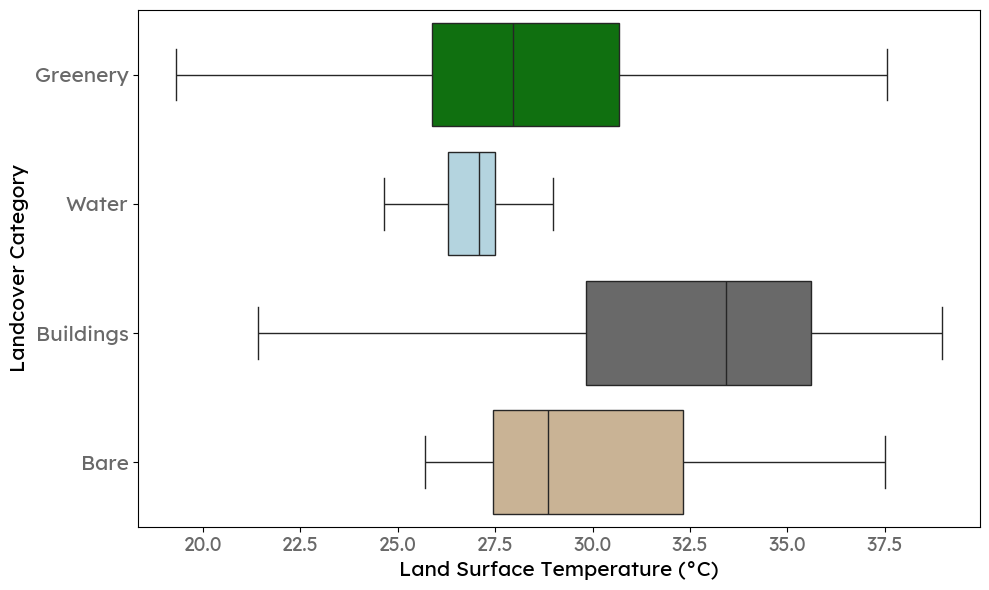

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))


ax = sns.boxplot(
    data=uhi_features,
    x="LST_C",
    y="Landcover Category",
    hue="Landcover Category",
    palette=custom_palette,
    linewidth=1,
    showfliers=False,
)

lexend_font = load_google_font("Lexend")
ax.set_xlabel("Land Surface Temperature (°C)", fontproperties=lexend_font, fontsize=15)
ax.set_ylabel("Landcover Category", fontproperties=lexend_font, fontsize=15)
# ax.set_title("Temperature Distributions", fontproperties=lexend_font, fontsize=16)
ax.set_title("", fontproperties=lexend_font, fontsize=16)

for label in ax.get_xticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(14)
    label.set_color("dimgray")

for label in ax.get_yticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(15)
    label.set_color("dimgray")

plt.tight_layout()
plt.savefig("landcover_boxplots.png")
plt.show()

In [24]:
# To calculate median temperatures per landcover category

print(uhi_features.groupby("Landcover Category")["LST_C"].mean())

Landcover Category
Bare         29.715294
Buildings    32.340183
Greenery     28.201544
Water        26.893158
Name: LST_C, dtype: float64


### Correlation Matrix

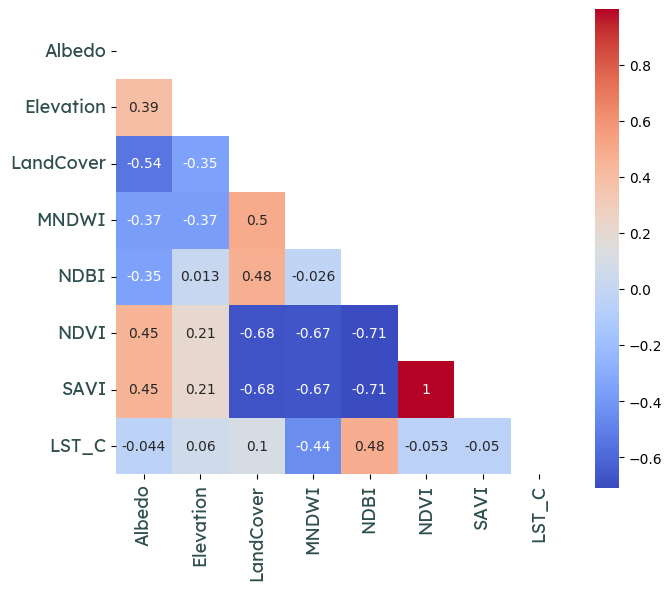

In [25]:
corr_matrix = uhi_features.drop(
    columns=["Landcover Category", "LST_K", "longitude", "latitude"]
).corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(7, 6))

# ax.set_title("Feature Correlation Matrix", fontproperties=lexend_font, fontsize=16)
ax.set_title("", fontproperties=lexend_font, fontsize=16)

for label in ax.get_xticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(13)
    label.set_color("darkslategray")

for label in ax.get_yticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(13)
    label.set_color("darkslategray")

sns.heatmap(corr_matrix, mask=mask, square=True, cmap="coolwarm", annot=True)
plt.tight_layout()
plt.savefig("feature_matrix.png")
plt.show()

## Building the Model

1. First, we define our features (predictors and response).
2. Next, we split our data into a training set and a test (validation) set.
3. Then, we train out model on the training set, and test it on the test set.
4. We can evaluate the model performance using the Root Mean Squared Error (RMSE) values.

In [26]:
import numpy as np
from sklearn.model_selection import (
    train_test_split,
)

import lightgbm
from sklearn.metrics import root_mean_squared_error, r2_score

In [ ]:
model_df = pd.read_csv("data/UHI_200_features.csv")
model_df

,Albedo,Elevation,LST,LandCover,MNDWI,NDBI,NDVI,SAVI,latitude,longitude
0,15019.7662,18,298.022254,10,-0.112645,-0.164508,0.281312,0.421961,6.679750,4.054622
1,9437.6502,0,301.641937,80,-0.056986,-0.048300,0.131416,0.197118,6.430854,4.100493
2,15982.7877,9,296.919943,10,-0.156783,-0.081515,0.215554,0.323326,6.534051,3.793818
3,13823.5322,6,307.083425,50,-0.119996,0.011778,0.076754,0.115129,6.428361,3.417995
4,12412.8202,4,302.672470,95,-0.101082,-0.195369,0.298264,0.447388,6.594710,3.447086
...,...,...,...,...,...,...,...,...,...,...
495,10291.9372,0,299.505675,80,-0.016148,-0.069854,0.085366,0.128046,6.609440,3.797326
496,9208.0952,0,299.456113,80,0.027337,-0.066441,0.038827,0.058239,6.541904,3.706865
497,13113.8842,17,303.188591,10,-0.124974,-0.148140,0.281481,0.422215,6.451533,3.964757
498,11956.5932,6,305.458156,60,-0.115826,-0.061563,0.170749,0.256119,6.512499,3.583615


In [28]:
#  IDENTIFYING THE FEATURES AND RESPONSE
model_df.rename(columns={"LST": "LST_K"}, inplace=True)

var_columns = [c for c in model_df.columns if c not in ["LST_K"]]

X = model_df.loc[:, var_columns]

y = model_df.loc[:, "LST_K"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_test.shape, y_test.shape

((400, 9), (100, 9), (100,), (100,))

In [29]:
# CREATE MODEL AND EVALUATE PERFORMANCE

train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

# SPECIFY PARAMETERS

parameters = {
    "objective": "regression",
    "metric": "rmse",
    "boosting": "gbdt",
    "num_leaves": 30,
    "feature_fraction": 0.6,
    "bagging_fraction": 0.5,
    "bagging_freq": 20,
    "learning_rate": 0.001,
    "min_child_samples": 40,
    "max_depth": 8,
    "verbose": -1,
}

# TRAIN THE MODEL FOR 5000 ROUNDS,
# EARLY STOPPING CRITERIA = 50 ITERATIONS

model_lgbm = lightgbm.train(
    parameters,
    train_data,
    valid_sets=test_data,
    num_boost_round=10000,
    callbacks=[lightgbm.early_stopping(stopping_rounds=100)],
)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4340]	valid_0's rmse: 2.97839


In [30]:
y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

print("Train RMSE: {:.4f}".format(root_mean_squared_error(y_train, y_train_pred)))
print("Test RMSE: {:.4f}".format(root_mean_squared_error(y_test, y_test_pred)))
print("Test R²: {:.4f}".format(r2_score(y_test, y_test_pred)))

Train RMSE: 2.6711
Test RMSE: 2.9784
Test R²: 0.5717


## Plotting the Error

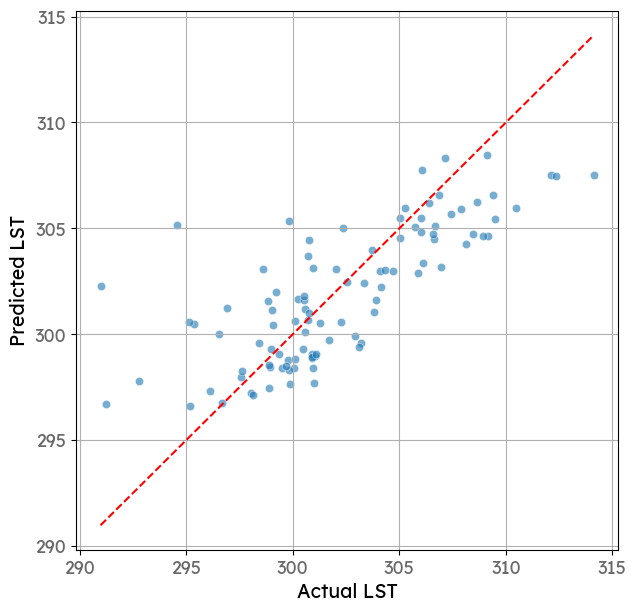

In [31]:
from pyfonts import load_google_font

lexend_font = load_google_font("Lexend")

fig, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, ax=ax)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
ax.set_xlabel("Actual LST", font_properties=lexend_font, fontsize=14)
ax.set_ylabel("Predicted LST", fontproperties=lexend_font, fontsize=14)
# ax.set_title("Actual vs Predicted LST", fontproperties=lexend_font, fontsize=16)
ax.set_title("", fontproperties=lexend_font, fontsize=16)

for label in ax.get_xticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(13)
    label.set_color("dimgray")

for label in ax.get_yticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(13)
    label.set_color("dimgray")
ax.grid(True)
plt.savefig("actual_and_predicted_scatter.png")
plt.show()


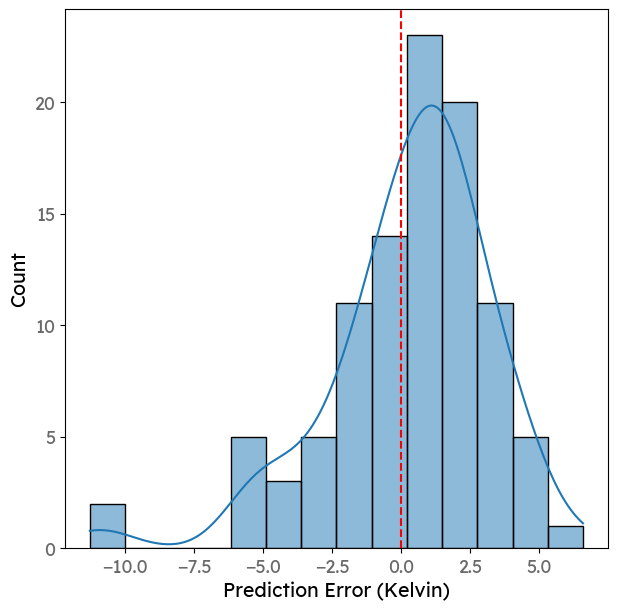

In [32]:
residuals = y_test - y_test_pred

fig, ax = plt.subplots(figsize=(7, 7))
sns.histplot(residuals, kde=True, ax=ax)
ax.axvline(0, color="red", linestyle="--")
# ax.set_title("Residual Distribution", font_properties=lexend_font, fontsize=16)
ax.set_title("", font_properties=lexend_font, fontsize=16)
ax.set_xlabel("Prediction Error (Kelvin)", font_properties=lexend_font, fontsize=14)
ax.set_ylabel("Count", font_properties=lexend_font, fontsize=14)

for label in ax.get_xticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(13)
    label.set_color("dimgray")

for label in ax.get_yticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(13)
    label.set_color("dimgray")

plt.savefig("residual_distribution.png")
plt.show()


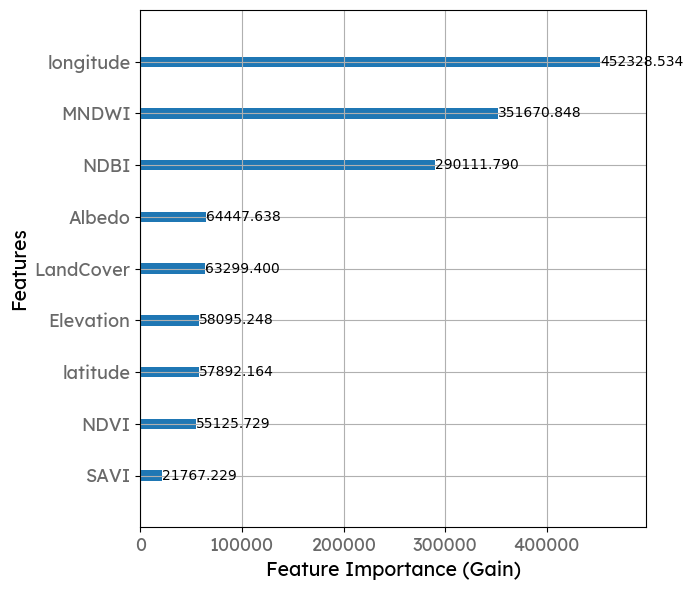

In [33]:
fig, ax = plt.subplots(figsize=(7, 6))

lightgbm.plot_importance(model_lgbm, max_num_features=10, importance_type="gain", ax=ax)

# ax.set_title("Most Important Features", fontproperties=lexend_font, fontsize=16)
ax.set_title("", fontproperties=lexend_font, fontsize=16)

ax.set_xlabel("Feature Importance (Gain)", fontproperties=lexend_font, fontsize=14)
ax.set_ylabel("Features", fontproperties=lexend_font, fontsize=14)

for label in ax.get_xticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(13)
    label.set_color("dimgray")

for label in ax.get_yticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(13)
    label.set_color("dimgray")

plt.tight_layout()
plt.savefig("feature_importances.png")
plt.show()

### Predicting on New Data

Now that we have obtained acceptable error values on our model's test set, and an overall okay R-squared value we can apply our model on new data.

That can be using the same process, but getting the non-LST values for each of the points we sample, and using them to predict the LST.

# Mapping UHI Intensity across Lagos

In [34]:
from rasterio.mask import mask
from shapely.geometry import Point

X = model_df.loc[:, var_columns]
model_df["Predicted_LST"] = model_lgbm.predict(X)

model_df["geometry"] = [Point(xy) for xy in zip(model_df.longitude, model_df.latitude)]
# Making GeoDataFrame for overlay plots
uhi_gdf = gpd.GeoDataFrame(model_df, geometry="geometry", crs="EPSG:4326")

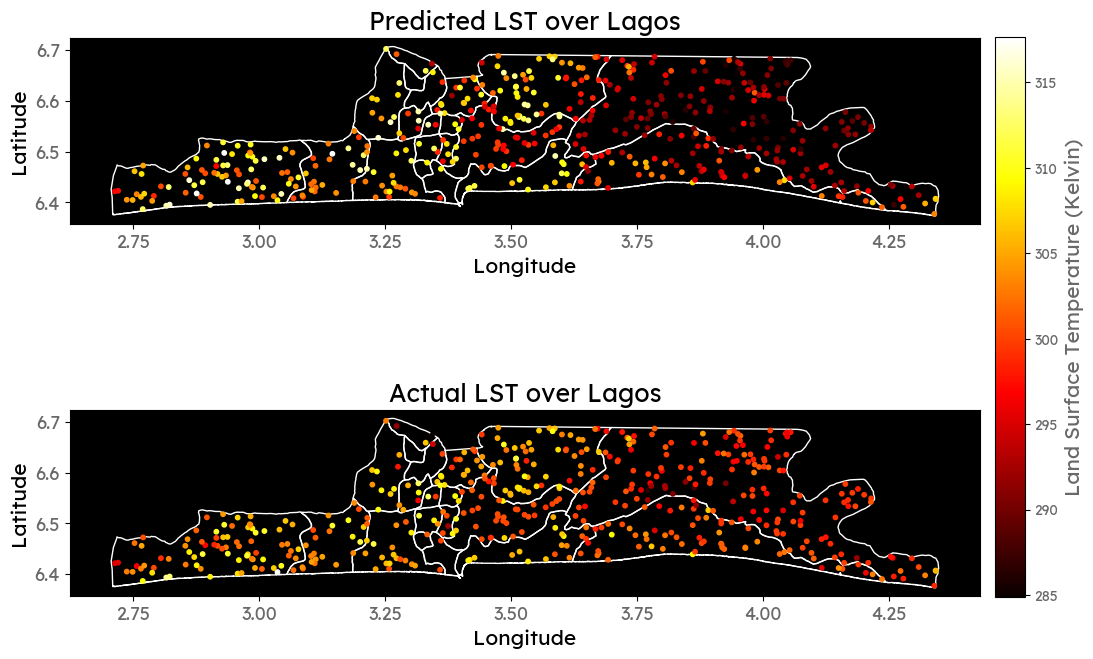

In [35]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

lagos.plot(ax=ax1, color="none", edgecolor="white")

# Overlay predicted LST
plot1 = uhi_gdf.plot(
    ax=ax1, column="Predicted_LST", cmap="hot", markersize=10, legend=False
)

ax1.set_title("Predicted LST over Lagos", fontproperties=lexend_font, fontsize=18)
ax1.set_xlabel("Longitude", fontproperties=lexend_font, fontsize=15, color="black")
ax1.set_ylabel("Latitude", fontproperties=lexend_font, fontsize=15, color="black")
ax1.set_facecolor("black")

lagos.plot(ax=ax2, color="none", edgecolor="white")

plot2 = uhi_gdf.plot(ax=ax2, column="LST_K", cmap="hot", markersize=10, legend=False)

ax2.set_title("Actual LST over Lagos", fontproperties=lexend_font, fontsize=18)
ax2.set_xlabel("Longitude", fontproperties=lexend_font, fontsize=15, color="black")
ax2.set_ylabel("Latitude", fontproperties=lexend_font, fontsize=15, color="black")
ax2.set_facecolor("black")

cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])

vmin = min(uhi_gdf["Predicted_LST"].min(), uhi_gdf["LST_K"].min())
vmax = max(uhi_gdf["Predicted_LST"].max(), uhi_gdf["LST_K"].max())

sm = plt.cm.ScalarMappable(cmap="hot", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm, cax=cbar_ax)

cbar.set_label(
    "Land Surface Temperature (Kelvin)",
    fontproperties=lexend_font,
    fontsize=15,
    color="dimgray",
)
cbar.ax.tick_params(labelsize=12, labelcolor="dimgray")
for t in cbar.ax.get_yticklabels():
    t.set_fontproperties(lexend_font)
    t.set_color("dimgray")

for ax in [ax1, ax2]:
    for label in ax.get_xticklabels():
        label.set_fontproperties(lexend_font)
        label.set_fontsize(13)
        label.set_color("dimgray")

    for label in ax.get_yticklabels():
        label.set_fontproperties(lexend_font)
        label.set_fontsize(13)
        label.set_color("dimgray")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("lst_heatplot.png", bbox_inches="tight", dpi=300)
plt.show()


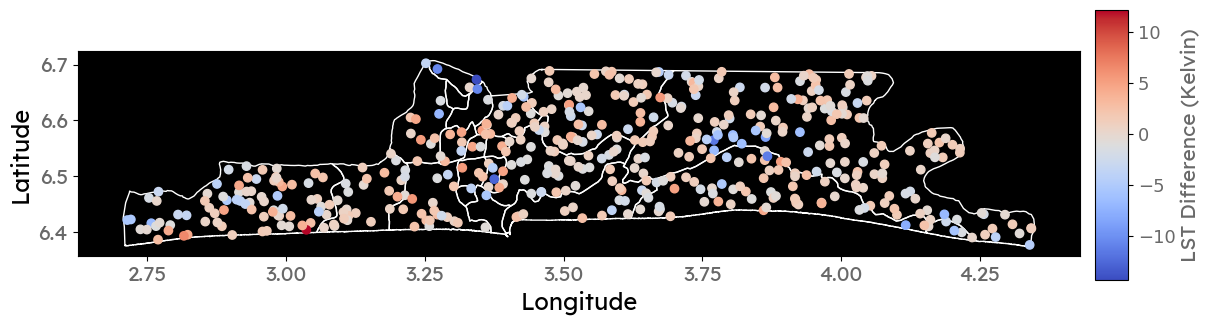

In [36]:
uhi_gdf["Error"] = uhi_gdf["LST_K"] - uhi_gdf["Predicted_LST"]

# print(uhi_gdf.columns)

fig, ax = plt.subplots(figsize=(11, 9))

lagos.plot(ax=ax, color="none", edgecolor="white")
uhi_gdf.plot(column="Error", cmap="coolwarm", legend=False, ax=ax)

# ax.set_title("LST Difference Map (Actual - Predicted)", fontproperties=lexend_font, fontsize=20)
ax.set_title("", fontproperties=lexend_font, fontsize=20)
ax.set_xlabel("Longitude", fontproperties=lexend_font, fontsize=17, color="black")
ax.set_ylabel("Latitude", fontproperties=lexend_font, fontsize=17, color="black")
ax.set_facecolor("black")

for label in ax.get_xticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(15)
    label.set_color("dimgray")

for label in ax.get_yticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(15)
    label.set_color("dimgray")

cbar_ax = fig.add_axes([1, 0.36, 0.03, 0.3])

vmin = uhi_gdf["Error"].min()
vmax = uhi_gdf["Error"].max()

sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm, cax=cbar_ax)

cbar.set_label(
    "LST Difference (Kelvin)",
    fontproperties=lexend_font,
    fontsize=15,
    color="dimgray",
)
cbar.ax.tick_params(labelsize=13, labelcolor="dimgray")


plt.tight_layout()
plt.savefig("lst_difference.png", bbox_inches="tight", dpi=300)
plt.show()


In [37]:
mu = uhi_gdf["LST_K"].mean()
sigma = uhi_gdf["LST_K"].std()
threshold = mu + 0.5 * sigma

uhi_gdf["UHI_class"] = np.where(uhi_gdf["LST_K"] > threshold, "UHI", "non-UHI")

uhi_mean = uhi_gdf[uhi_gdf["UHI_class"] == "UHI"]["LST_K"].mean()
non_uhi_mean = uhi_gdf[uhi_gdf["UHI_class"] == "non-UHI"]["LST_K"].mean()
uhi_intensity = uhi_mean - non_uhi_mean

print(mu, sigma, threshold)
print(f"UHI Intensity: {uhi_intensity:.2f}K")


302.10627859502 4.368627715520711 304.29059245278034
UHI Intensity: 7.52K


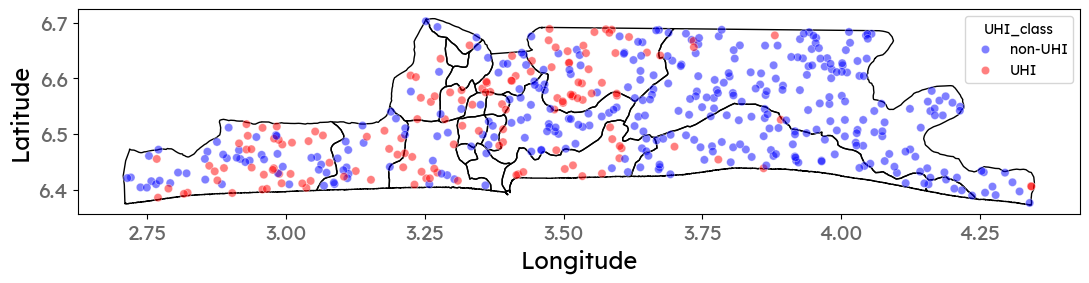

In [38]:
fig, ax = plt.subplots(figsize=(11, 9))

lagos.plot(ax=ax, color="none", edgecolor="black")
ax = sns.scatterplot(
    x="longitude",
    y="latitude",
    hue="UHI_class",
    palette={"UHI": "red", "non-UHI": "blue"},
    alpha=0.5,
    data=uhi_gdf,
)

# ax.set_title("UHI and Non-UHI Areas", fontproperties=lexend_font, fontsize=20)
ax.set_title("", fontproperties=lexend_font, fontsize=20)
ax.set_xlabel("Longitude", fontproperties=lexend_font, fontsize=17, color="black")
ax.set_ylabel("Latitude", fontproperties=lexend_font, fontsize=17, color="black")
# ax1.set_facecolor("black")


legend = ax.get_legend()

# Apply font properties to legend title and labels if lexend_font is defined
if "lexend_font" in locals() or "lexend_font" in globals():
    for text in legend.get_texts():
        text.set_fontsize(14)
        text.set_fontproperties(lexend_font)
    if legend.get_title():
        legend.get_title().set_fontsize(16)
        legend.get_title().set_fontproperties(lexend_font)

for label in ax.get_xticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(15)
    label.set_color("dimgray")

for label in ax.get_yticklabels():
    label.set_fontproperties(lexend_font)
    label.set_fontsize(15)
    label.set_color("dimgray")

plt.tight_layout()
plt.savefig("uhi_areas.png", bbox_inches="tight", dpi=300)
plt.show()

In [39]:
uhi_gdf = uhi_gdf.set_crs("EPSG:4326")
lagos = lagos.to_crs(uhi_gdf.crs)

# Add district name from lagos to each point in uhi_gdf
uhi_gdf_district = gpd.sjoin(
    uhi_gdf, lagos[["NAME_2", "geometry"]], how="left", predicate="within"
)
uhi_gdf_district.rename(columns={"NAME_2": "District"}, inplace=True)

In [40]:
summary = (
    uhi_gdf_district.groupby("District")
    .agg(
        Mean_LST=("LST_K", "mean"),
        Std_LST=("LST_K", "std"),
        Mean_Predicted_LST=("Predicted_LST", "mean"),
        Std_Predicted_LST=("Predicted_LST", "std"),
        Mean_Error=("Error", "mean"),
        Std_Error=("Error", "std"),
        UHI_Count=("UHI_class", lambda x: (x == "UHI").sum()),
        Non_UHI_Count=("UHI_class", lambda x: (x == "non-UHI").sum()),
    )
    .reset_index()
)

In [41]:
uhi_gdf.groupby("UHI_class")["LST_K"].agg(["mean", "std", "count"])

,mean,std,count
UHI_class,,,
UHI,307.491481,2.310181,142
non-UHI,299.970249,2.908205,358


In [42]:
print(summary)

        District    Mean_LST    Std_LST  Mean_Predicted_LST  \
0       Alimosho  306.018883   3.669488          305.650186   
1   Amuwo Odofin  304.708585   2.779476          303.836222   
2          Apapa  300.057685        NaN          305.451205   
3        Badagry  304.865355   4.358059          304.668019   
4            Epe  298.903785   3.074172          299.018548   
5        Eti-Osa  305.238169   2.898818          304.806651   
6    Ibeju-Lekki  301.138947   3.018927          301.106467   
7    Ifako/Ijaye  294.403710  11.054832          302.639374   
8          Ikeja  297.352322   3.934722          303.300832   
9        Ikorodu  304.247689   3.419190          303.929555   
10        Kosofe  303.939751   2.999948          303.331443   
11  Lagos Island  301.365632   2.765482          301.806491   
12      Mainland  300.890998   6.019867          303.250082   
13        Mushin  307.204765   6.744758          305.276666   
14           Ojo  304.274952   3.215603          303.79